# IEEE CIS Fraud Detection 
This is a side project I did recently on Kaggle datasets called IEEE CIS Fraud Detection. 
* The task is to detect fraud transactions from the provided datasets.
* Original datasets have a training set, a testing set. However, for this task, I will split the original training set to 2 parts--a training set with cross-validation and a testing set.


The outline of the work includes the following:
* Import the datasets
* Knowing and cleaning the data
* Exploratory data analysis and feature selection
* Train a ridge model
* Train a random forest model and feature selection
* Train a XGBoost model
* Summary



Let us start real quick!

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeClassifierCV, RidgeClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
#import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

# Import the datasets

In [3]:
train_transaction = pd.read_csv(r'/Users/alex_chloe/Desktop/kaggle/train_transaction.csv')
train_identity = pd.read_csv(r'/Users/alex_chloe/Desktop/kaggle/train_identity.csv')
train_transaction_full = train_transaction.merge(train_identity, how = 'left', 
                                                 left_on = 'TransactionID', right_on = 'TransactionID')


# Knowing and cleaning the data
First of all, we want to know some detail about the dataset, so let's do it!

In [4]:
#shape
print(train_transaction_full.shape)

(590540, 434)


In [5]:
train_transaction_full.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
train_transaction_full.describe(include = 'all')

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540,590540.000000,581607.000000,588975.000000,588963,586281.000000,...,140282,77586.000000,73289,77805,140985,140985,140985,140985,140810,118666
unique,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,4,NaN,...,130,NaN,260,4,2,2,2,2,2,1786
top,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,visa,NaN,...,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,NaN,NaN,NaN,NaN,439670,NaN,NaN,NaN,384767,NaN,...,22000,NaN,16874,60011,77814,134066,110452,73922,85165,47722
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,NaN,9898.734658,362.555488,153.194925,NaN,199.278897,...,NaN,26.508597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.704744e+05,0.183755,4.617224e+06,239.162522,NaN,4901.170153,157.793246,11.336444,NaN,41.244453,...,NaN,3.737502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.987000e+06,0.000000,8.640000e+04,0.251000,NaN,1000.000000,100.000000,100.000000,NaN,100.000000,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,NaN,6019.000000,214.000000,150.000000,NaN,166.000000,...,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,NaN,9678.000000,361.000000,150.000000,NaN,226.000000,...,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,NaN,14184.000000,512.000000,150.000000,NaN,226.000000,...,NaN,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So this dataset has 590540 rows and 434 columns! Based on the info provided by the IEEE, we know that 

1) Transaction tables
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual   meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
ProductCD
card1 - card6
addr1, addr2
Pemaildomain Remaildomain
M1 - M9

2) Identity tables

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
DeviceType
DeviceInfo
id12 - id38

As we can see a lot of missing values in the table and the categorical features are not handled, we need to do some cleaning first.


How many of the observations are fraud? I suppose this dataset may be highly skewed.

In [7]:
fraudcases, _ = train_transaction_full[train_transaction_full['isFraud'] == True].shape
nonfraudcases, _ = train_transaction_full[train_transaction_full['isFraud'] == False].shape
print("the fraud cases are {}, and the non-fraud cases are {}".format(fraudcases, nonfraudcases))

the fraud cases are 20663, and the non-fraud cases are 569877


So we need to be aware of the fact that this dataset is very skewed which could indicate accuracy is not a good criterion in our final prediction task. 

In [8]:
# drop columns that are more than 90% with NAs
#usecolumns = []
#len_rows,len_columns = train_transaction_full.shape
#for i in range(len_columns):
#    naportion = train_transaction_full.iloc[:, i].isna().sum() / len_rows
#    if(naportion <= 0.90):
#        usecolumns.append(train_transaction_full.columns[i])
train_transaction_full = train_transaction_full.loc[:, train_transaction_full.isnull().mean()<0.8]

In [9]:
train_transaction_full.columns.values

array(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1',
       'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38',
       'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56',
       'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65',
       'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74',
       '

Categorical variables need to be one-hot encoded

In [10]:
column_names_cat = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'P_emaildomain','R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_15', 'id_16', 'id_17',
       'id_19', 'id_20', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo']

However, here comes a problem. Some variables contain ridiculously large number of different levels which 
we should do one-hot encoding on. For instance, 'addr1', let's show how many different variables addr1 have

In [11]:
len(train_transaction_full['addr1'].unique())

333

As you see, this will be an issue for machine learning algorithm because if we one-hot encodes every variable like this than we wind up having a huge training set. One strategy is to drop such columns once and for all, but this may otherwise results in loss of useful info. The other solution is to just encode the first several categories by occurrences then the rest as 'other'. In this project, I chose the latter.

In [12]:
for column in column_names_cat:
    cat = train_transaction_full[train_transaction_full['isFraud'] == True].    \
                loc[:, column].value_counts(dropna = False).nlargest(n=10).index
    yesorno = [ value not in cat for value in train_transaction_full.loc[:,column]]
    train_transaction_full.loc[yesorno,column] = 'other'

Now, let us do one-hot encoding. Notice in this case, we cannot decide which variable is ordinal given the info IEEE provides. So I assume every variable is nominal. 

In [13]:
train_transaction_full_cat = train_transaction_full.loc[:, column_names_cat]
train_transaction_full_cat = pd.get_dummies(train_transaction_full_cat, dummy_na = False)

In [14]:
# sanity check
train_transaction_full_cat.head()

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card1_2616,card1_5812,card1_6019,card1_9026,card1_9500,...,DeviceInfo_LG-D320 Build/KOT49I.V10a,DeviceInfo_MacOS,DeviceInfo_SM-A300H Build/LRX22G,DeviceInfo_Trident/7.0,DeviceInfo_Windows,DeviceInfo_hi6210sft Build/MRA58K,DeviceInfo_iOS Device,DeviceInfo_other,DeviceInfo_rv:11.0,DeviceInfo_rv:57.0
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Now let's impute the missing values (NAs). 

In [15]:
column_names_notinterested = ['isFraud', 'TransactionID', 'TransactionDT']
column_names_noncat = [name for name in train_transaction_full.columns.tolist() 
                       if name not in column_names_cat and name not in column_names_notinterested]

In [16]:
fill_NaN = SimpleImputer(missing_values=np.nan, strategy='median')
train_transaction_full_noncat = train_transaction_full.loc[:,column_names_noncat]

train_transaction_full_noncat = pd.DataFrame(fill_NaN.fit_transform(train_transaction_full_noncat), 
                                                 columns = train_transaction_full_noncat.columns)


Now we can concatenate the one-hot encoded cat and imputed non-cat datasets for a new dataset!

In [17]:
X_train_full = pd.concat([train_transaction_full_cat, train_transaction_full_noncat], axis = 1, sort=False)

In [18]:
print(X_train_full.shape)

(590540, 516)


merge X_train_full and y_train_full as train_full for exploratory data analysis (EDA) purpose!

In [19]:
train_full = pd.concat([X_train_full, train_transaction_full['isFraud']], axis = 1, sort = False)
train_full['isFraud'] = train_full['isFraud'].map({1:'Fraud',0:'Not Fraud'})

# Exploratory Data Analysis and Feature Selection
Let us do some exploratory data analysis to know what distribution the continuous features may follow and how they are correlated (I do think feature selection and engineering is important (except using tree-based method) but this exploratory data analysis may serve to let me know more about the data)

In [20]:
train_transaction_fraud = train_full[train_full['isFraud'] == 'Fraud']
train_transaction_nonfraud = train_full[train_full['isFraud'] == 'Not Fraud']

I want to show some distribution plots of some continuous variables to have some intuition about what they look like.

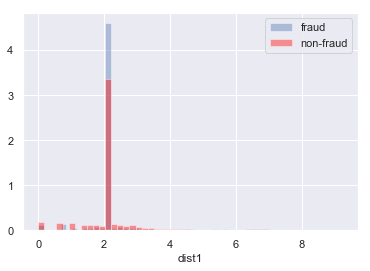

In [21]:
fig, ax = plt.subplots()
sns.distplot(np.log(train_transaction_fraud['dist1']+1), kde = False, ax = ax, norm_hist = True)
sns.distplot(np.log(train_transaction_nonfraud['dist1']+1), kde = False, color = 'red', ax = ax, norm_hist = True)
plt.legend(labels = ['fraud', 'non-fraud'])
#train_full['logdist1'] = np.log(train_full['dist1']+1)
#sns.boxplot(y = 'logdist1',x = 'isFraud', data = train_full, ax = ax)


(0, 2000)

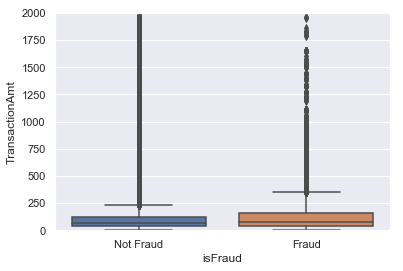

In [22]:
fig, ax = plt.subplots()
#train_full['TransactionAmt'].loc[train_full['TransactionAmt'] > 30000] = 0
sns.boxplot(y = 'TransactionAmt',x = 'isFraud', data = train_full, ax = ax)
ax.set_ylim([0, 2000])

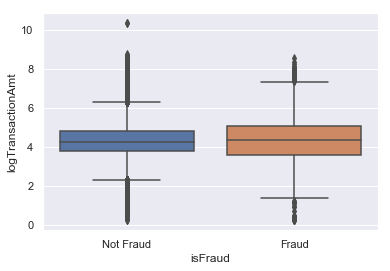

In [23]:
#logtransform
#As the data is highly skewed 
fig, ax = plt.subplots()
#sns.distplot(np.log(train_transaction_fraud['TransactionAmt']+1), kde = False, ax = ax, norm_hist = True)
#sns.distplot(np.log(train_transaction_nonfraud['TransactionAmt']+1), kde = False, 
#             color = 'red', ax = ax, norm_hist = True)
#plt.legend(labels = ['fraud', 'non-fraud'])
train_full['logTransactionAmt'] = np.log(train_full['TransactionAmt']+1)
sns.boxplot(y = 'logTransactionAmt',x = 'isFraud', data = train_full, ax = ax)

Looks like the distribution of fraud log transaction amount is broader than that of the not fraud counterpart. But such difference may not be ideal as they have a large part overlapping to each other. Let us do more anyway!

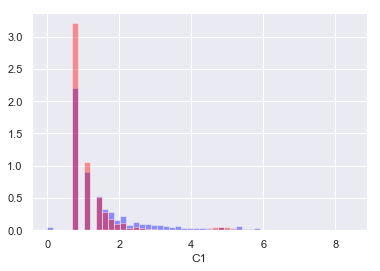

In [54]:
fig, ax = plt.subplots()
sns.distplot(np.log(train_transaction_fraud['C1']+1), kde = False, color = 'blue', ax = ax, norm_hist = True)
sns.distplot(np.log(train_transaction_nonfraud['C1']+1), kde = False, color = 'red', ax = ax, norm_hist = True)

As we see above, the log-transformed plot after normalization shows some differences! However, I think this is hopeless to plot all the distribution histograms manually of the columns to let us discern useful information to do feature engineering this way.

In [25]:
#correlation matrix to see which columns are highly correlated with classifications
corr_X_train = X_train_full.corr()

In [26]:
upper = corr_X_train.where(np.triu(np.ones(corr_X_train.shape), k=1).astype(np.bool))
# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.95)]

In [27]:
X_train_full = X_train_full.drop(columns = to_drop,axis = 1)

In [28]:
X_train_full.shape

(590540, 422)

# Train a ridge classification model 

In [55]:
y_train_full = train_full['isFraud'].map({'Fraud': 1,'Not Fraud': 0})

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=1)
clf = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
y_test_pred = clf.predict(X_test) 
confusion_matrix(y_test, y_test_pred)

array([[102622,  11352],
       [  2911,   1223]])

Looks rather bad, right? We end up misclassifying lots of good ones into fraud ones which means our model has a very high false positive rate. So I think there are two simple things to try at first to improve: 1) the continuous variables are not standardized which may cause the model training to have some problems. 2) maybe applying log transform to the continuous variables is something we can do at the moment. let's standardize the continuous variables after taking log transform and see if there is any difference!

In [50]:
for train_noncat_column in train_transaction_full_noncat.columns:
    if(np.min(train_transaction_full_noncat[train_noncat_column]) > 0):
        if(train_transaction_full_noncat[train_noncat_column].skew(axis = 0) > 5):
            train_transaction_full_noncat[train_noncat_column] = np.log(train_transaction_full_noncat[train_noncat_column])
    elif(np.min(train_transaction_full_noncat[train_noncat_column]) == 0):
        if(train_transaction_full_noncat[train_noncat_column].skew(axis = 0) > 5):
            train_transaction_full_noncat[train_noncat_column] = np.log(train_transaction_full_noncat[train_noncat_column] + 1)
#train_transaction_full_noncat.skew(axis = 0, skipna = True) 
#train_transaction_full_noncat['V5'].hist()

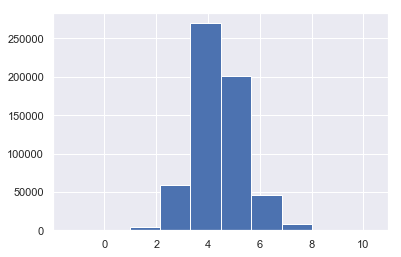

In [60]:
#sanity check of the log transforms
pd.Series(train_transaction_full_noncat['TransactionAmt']).hist()

In [52]:
scaler = StandardScaler(with_std = False)
train_transaction_full_noncat_scaled = pd.DataFrame(scaler.fit_transform(train_transaction_full_noncat), 
                                                    columns = train_transaction_full_noncat.columns)
X_train_full_scaled = pd.concat([train_transaction_full_cat, 
                                 train_transaction_full_noncat_scaled], axis = 1, sort=False)

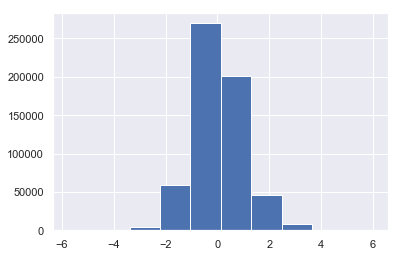

In [62]:
#sanitty check of the standardscaler
X_train_full_scaled['TransactionAmt'].hist()

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_train_full_scaled, y_train_full, test_size=0.2, random_state=1)
clf = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
y_test_pred = clf.predict(X_test) 
confusion_matrix(y_test, y_test_pred)

array([[102638,  11336],
       [  2911,   1223]])

Still terrible! Maybe ridge classifier is not an ideal choice here! Maybe we can do better with more feature engineering such as adding high-order polynomial features. But this would wind up making our feature space too big for the computer to handle. As I will give up on the ridge classifier I want to try the decision-tree based algorithms as these algorithms in general handle tabulated data pretty well!

# Train a random forest model and feature selection 

In [63]:
X_train_full.shape

(590540, 422)

I do a random forest training first because I want to evaluate the feature importance!

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished


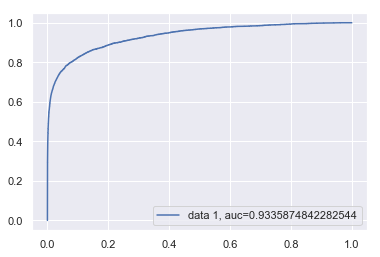

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=30, min_samples_leaf = 4, 
                             random_state=0, verbose = True, n_jobs = -1)
clf.fit(X_train, y_train)  
y_pred_train = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [70]:
y_test_pred = clf.predict(X_test)
confusion_matrix(y_test, y_test_pred, labels = [1, 0])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished


array([[113863,    111],
       [  2584,   1550]])

Much better compared with ridge classifier. But still not good enough. One thing we could do at the moment is to look into the feature importance in order to remove some highly redundant features.

In [71]:
feature_importance = pd.Series(clf.feature_importances_, index = X_train.columns)

In [72]:
feature_importance.sort_values(ascending = False)[:20]

C1                0.035353
C13               0.026485
V257              0.022973
V258              0.020115
V189              0.019833
V45               0.019014
TransactionAmt    0.018954
C7                0.018131
V200              0.017917
V201              0.017198
V242              0.014108
V190              0.014101
V44               0.013890
V246              0.013619
V87               0.012942
V243              0.012218
V294              0.012086
V188              0.011679
D15               0.010053
V274              0.009793
dtype: float64

There is no particular reason but I just want to select the first 400 features for the future model training.

In [73]:
X_train_full_mostimportant = X_train_full[feature_importance.sort_values(ascending = False).index[:400]]

In [142]:
#for i in range(3):
X_train, X_test, y_train, y_test = train_test_split(X_train_full_mostimportant, y_train_full, test_size=0.2, random_state=1)

# Grid Search
# Create the parameter grid based on the results of random search 
param_grid = {
         'bootstrap': [True],
         'max_depth': [25,30,35],
         'min_samples_leaf': [2,4],
         'min_samples_split': [2,4],
         'n_estimators': [100]
}
#Create a based model
folds = 5
rf = RandomForestClassifier(verbose = True)
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1)
#Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                              cv = skf, n_jobs = -1, verbose = 10)
grid_search.fit(X_train, y_train)
grid_search.best_params_


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 54.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 83.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 89.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 89.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.8min finished


{'bootstrap': True,
 'max_depth': 35,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 100}

It turns out the grid CV selects the above hyperparameters for the random forest model and let's see how different this could be!

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished


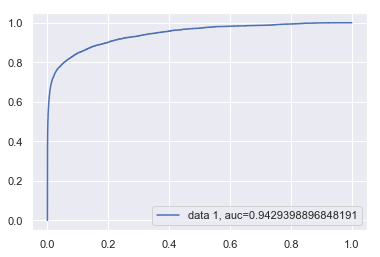

In [74]:
clf = RandomForestClassifier(n_estimators=100, max_depth=35, min_samples_split = 4,
                             random_state=0, verbose = True, n_jobs = -1)
clf.fit(X_train,y_train) 
y_pred_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [75]:
y_test_pred = clf.predict(X_test)
confusion_matrix(y_test, y_test_pred, labels = [1, 0])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished


array([[113872,    102],
       [  2293,   1841]])

# Train a XGboost model

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_train_full_mostimportant, y_train_full, test_size=0.2, random_state=2)

In [78]:
clf = XGBClassifier(max_depth=10,
                    min_child_weight=1,
                    learning_rate=0.1,
                    n_estimators=300,
                    #silent=True,
                    objective='binary:logistic',
                    gamma=0,
                    max_delta_step=0,
                    subsample=1,
                    colsample_bytree=1,
                    colsample_bylevel=1,
                    reg_alpha=0,
                    reg_lambda=0,
                    scale_pos_weight=1,
                    seed=1,
                    missing=None,
                    verbosity = 1)

clf.fit(X_train, y_train)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0, scale_pos_weight=1, seed=1, silent=None, subsample=1,
       verbosity=1)

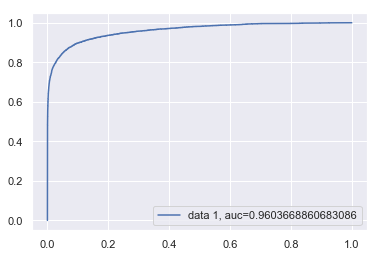

In [79]:
y_pred_proba = clf.predict_proba(X_test)[:,1]
#print(y_test)
#print(y_pred_proba)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [82]:
y_test_pred = clf.predict(X_test)
confusion_matrix(y_test, y_test_pred)

array([[113845,    139],
       [  1765,   2359]])

As we can see, the result is improved a lot with the XGBoost model. I have not yet applied a full cross validation to tune the hyperparameters yet, and the above hyperparameters with some previous mess-arounds. However, a full cross validation with grid search will take a fairly long period of time while randomized search scheme will take less time but still be time consuming. The following steps always get my jupyter notebook reload, but I just show it here for reference.

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [8, 10]
}


xgb = XGBClassifier(learning_rate=0.1, n_estimators=300, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb,
                                   scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1)
random_search.fit(X_train, y_train)


# Summary
* In this project, I first cleaned the datasets by imputing the noncategorical features and one-hot encoding the categorical features
* I then did exploratory data analysis and feature selection of the data
* I trained ridge classifier, random forest classifier and xgboost classifier with the datasets
In general, ridge classifier is not ideal given the existing features and more feature engineering may be required to boost the detection outcome. Random forest improves the result a lot but still have overall 50% false negative rate. The best model till now is the XGboost model which gives ~ 40% false negative rate. Still I may be able to improve the result even better if a full cross-validation can be performed. 